# Feature vector를 input data로 사용하는 Ensemble 모델

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# Sklearn Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    auc
)

## XGBoost

In [ ]:
# 파일 경로 설정
train_feature_file = f"{base_path}/FeatureVector/train_features.npy"
train_label_file = f"{base_path}/FeatureVector/train_labels.npy"
dev_feature_file = f"{base_path}/FeatureVector/dev_features.npy"
dev_label_file = f"{base_path}/FeatureVector/dev_labels.npy"
test_feature_file = f"{base_path}/FeatureVector/test_features.npy"
test_label_file = f"{base_path}/FeatureVector/test_labels.npy"

# Train 및 Dev 데이터 로드
train_features = np.load(train_feature_file)
train_labels = np.load(train_label_file)
dev_features = np.load(dev_feature_file)
dev_labels = np.load(dev_label_file)

# Train-Dev 합치기
X_train = np.vstack((train_features, dev_features))
y_train = np.hstack((train_labels, dev_labels))

# Test 데이터 로드
X_test = np.load(test_feature_file)
y_test = np.load(test_label_file)

# XGBoost 모델 학습
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## lightGBM

In [ ]:
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)

# LightGBM 모델 설정
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20
}

# LightGBM 모델 학습
lgb_model = lgb.train(params, train_data, num_boost_round=100)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 45425, number of negative: 45334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 90759, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500501 -> initscore=0.002005
[LightGBM] [Info] Start training from score 0.002005


## Ensemble

In [ ]:
output_csv = "./prediction_output_Ensemble.csv"   # 결과 저장 경로

# XGBoost 확률 예측
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]  # 클래스 1의 확률만 추출

# LightGBM 확률 예측
lgbm_probabilities = lgb_model.predict(X_test)  # LightGBM의 predict는 확률값 반환

# 확률 평균 (비슷한 성능이라 확률적으로 앙상블 진행)
ensemble_probabilities = (xgb_probabilities + lgbm_probabilities) / 2

# 최종 클래스 예측 (Threshold = 0.5)
ensemble_predictions = (ensemble_probabilities > 0.5).astype(int)

# 결과 저장
ensemble_output_data = pd.DataFrame({
    "label": y_test,
    "predicted_label": ensemble_predictions
})

# 저장
ensemble_output_data.to_csv(output_csv, index=False)
print("Ensemble predictions saved to ensemble_output.csv")

ensemble_output_data.head()


Ensemble predictions saved to ensemble_output.csv


,label,predicted_label
0,0,0
1,0,1
2,0,0
3,1,1
4,1,1


# 모델 성능 평가

In [ ]:
# Classification report

# 원래 라벨과 예측된 라벨 추출
true_labels = ensemble_output_data['label']
predicted_labels = ensemble_output_data['predicted_label']

# Classification Report 생성
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])

# 출력
print("[ DNABERT + Ensemble ]",'\n')
print("Classification Report:")
print(report)

[ DNABERT + Ensemble ] 

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.91      0.94      8054
     Class 1       0.92      0.96      0.94      7963

    accuracy                           0.94     16017
   macro avg       0.94      0.94      0.94     16017
weighted avg       0.94      0.94      0.94     16017



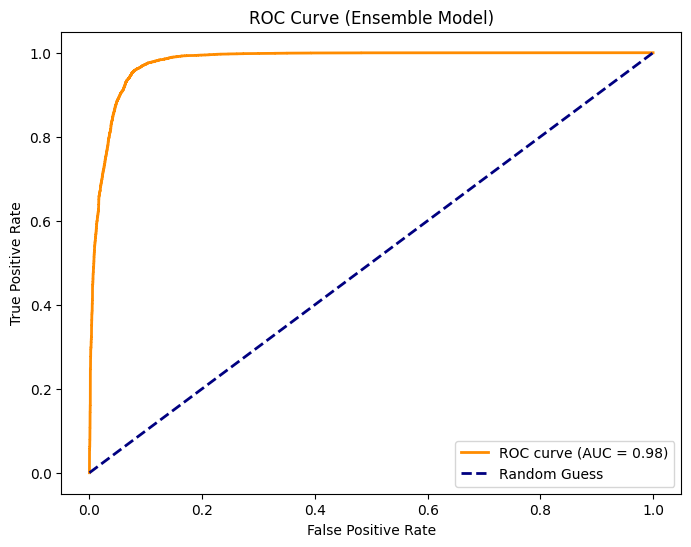

AUC (Area Under the Curve): 0.9791


In [ ]:
# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, ensemble_probabilities)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Ensemble Model)')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

# AUC 출력
print(f"AUC (Area Under the Curve): {roc_auc:.4f}")